### Visualize the PHOCNet results with BCE logit loss

In [1]:
import argparse
import logging

import numpy as np
import torch.autograd
import torch.cuda
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
import tqdm

import copy
from datasets.maps_alt import MAPSDataset

#from cnn_ws.transformations.homography_augmentation import HomographyAugmentation
from cnn_ws.losses.cosine_loss import CosineLoss

from cnn_ws.models.myphocnet import PHOCNet
from cnn_ws.evaluation.retrieval import map_from_feature_matrix, map_from_query_test_feature_matrices
from torch.utils.data.dataloader import _DataLoaderIter as DataLoaderIter
from torch.utils.data.sampler import WeightedRandomSampler

from cnn_ws.utils.save_load import my_torch_save, my_torch_load

#import matplotlib.pyplot as plt

In [2]:
# def learning_rate_step_parser(lrs_string):
#     return [(int(elem.split(':')[0]), float(elem.split(':')[1])) for elem in lrs_string.split(',')]

In [3]:
# # parameters
# embedding_type = 'phoc'
# phoc_unigram_levels = [1,2,4,8]
# fixed_image_size = None
# min_image_width_height = 26

In [4]:
# f = open('../splits/val_files.txt', 'rb')
# all_files = f.readlines()
# all_files = [x.strip('\n') for x in all_files]
# f.close()

# test_set = MAPSDataset(map_root_dir1='../../words/original_images/nopad/',
#                 map_root_dir2='../../words/original_words/nopad/',
#                 all_files=all_files,
#                 embedding=embedding_type,
#                 phoc_unigram_levels=phoc_unigram_levels,
#                 fixed_image_size=fixed_image_size,
#                 min_image_width_height=min_image_width_height)

In [5]:
if not torch.cuda.is_available():
    logger.warning('Could not find CUDA environment, using CPU mode')
    gpu_id = None
else:
    gpu_id = [0]
#torch.cuda.get_device_name(gpu_id[0])
pass

In [6]:
# test_set.mainLoader(partition='test', transforms=None)

In [7]:
# test_loader = DataLoader(test_set,
#     batch_size=1,
#     shuffle=False,
#     num_workers=8)

In [8]:
# save the model in new format so its easy to read
#model_ = torch.load('PHOCNet.pt')
#model_parameters = {name : param.data for name, param in model_.named_parameters()}
#torch.save(model_parameters, 'PHOCNet_new.pt')

In [9]:
# cnn = PHOCNet(n_out=list(test_set[0][1].size())[0],
#     input_channels=3,
#     gpp_type='gpp',
#     pooling_levels=([1], [5]))

# cnn.init_weights()

# #print list(cnn.named_parameters())
# pass

In [10]:
# '''
# my_torch_load(cnn, 'PHOCNet_new.pt')

# if gpu_id is not None:
#         if len(gpu_id) > 1:
#             cnn = nn.DataParallel(cnn, device_ids=gpu_id)
#             cnn.cuda()
#         else:
#             cnn.cuda(gpu_id[0])
# '''
# pass
# #print list(cnn.named_parameters())

In [11]:
model_ = torch.load('models/PHOCNet_a.pt')
cnn = model_.module#list(model_.named_parameters())
if gpu_id is not None:
        if len(gpu_id) > 1:
            cnn = nn.DataParallel(cnn, device_ids=gpu_id)
            cnn.cuda()
        else:
            cnn.cuda(gpu_id[0])
cnn.training = False

In [12]:
# def evaluate_cnn(cnn, dataset_loader, gpu_id):
#     logger = logging.getLogger('PHOCNet-Experiment::test')
#     # set the CNN in eval mode
#     cnn.eval()
#     logger.info('Computing net output:')
#     qry_ids = [] #np.zeros(len(dataset_loader), dtype=np.int32)
#     class_ids = np.zeros(len(dataset_loader), dtype=np.int32)
#     embedding_size = dataset_loader.dataset.embedding_size()
#     embeddings = np.zeros((len(dataset_loader), embedding_size), dtype=np.float32)
#     outputs = np.zeros((len(dataset_loader), embedding_size), dtype=np.float32)
#     eq = []
#     for sample_idx, (word_img, embedding, class_id, is_query) in enumerate(tqdm.tqdm(dataset_loader)):
#         #print(word_img.shape)
#         if len(word_img.shape) > 4:
#             #word_img = np.squeeze(word_img, axis=0)
#             word_img = word_img[0]
#         #print(word_img.shape)
#         if gpu_id is not None:
#             # in one gpu!!
#             word_img = word_img.cuda(gpu_id[0])
#             embedding = embedding.cuda(gpu_id[0])
#             #word_img, embedding = word_img.cuda(args.gpu_id), embedding.cuda(args.gpu_id)
        
#         word_img = torch.autograd.Variable(word_img)
#         embedding = torch.autograd.Variable(embedding)
#         ''' BCEloss ??? '''
#         output = torch.sigmoid(cnn(word_img))
#         #output = cnn(word_img)
#         outputs[sample_idx] = output.data.cpu().numpy().flatten()
#         embeddings[sample_idx] = embedding.data.cpu().numpy().flatten()
#         class_ids[sample_idx] = class_id.numpy()[0,0]
#         #eq = []
#         if is_query[0] == 1:
#             qry_ids.append(sample_idx)  #[sample_idx] = is_query[0]
#             eq.append(embeddings[sample_idx])

#     '''
#     # find queries

#     unique_class_ids, counts = np.unique(class_ids, return_counts=True)
#     qry_class_ids = unique_class_ids[np.where(counts > 1)[0]]

#     # remove stopwords if needed
    
#     qry_ids = [i for i in range(len(class_ids)) if class_ids[i] in qry_class_ids]
#     '''

#     qry_outputs = outputs[qry_ids][:]
#     qry_class_ids = class_ids[qry_ids]

#     # run word spotting
#     logger.info('Computing mAPs...')

#     ave_precs_qbe = map_from_query_test_feature_matrices(query_features = qry_outputs,
#                                                          test_features=outputs,
#                                                          query_labels = qry_class_ids,
#                                                          test_labels=class_ids,
#                                                          metric='cosine',
#                                                          drop_first=True)

#     logger.info('mAP: %3.2f', np.mean(ave_precs_qbe[ave_precs_qbe > 0])*100)
#     print 'mAP: ', np.mean(ave_precs_qbe[ave_precs_qbe > 0])*100
#     return outputs, qry_ids, class_ids, eq

In [13]:
# # evaluation (checking if I was correct or not)
# outputs, qry_ids, class_ids, eq = evaluate_cnn(cnn=cnn,
#         dataset_loader=test_loader,
#         gpu_id=gpu_id)

In [14]:
# #print outputs.shape, len(qry_ids), class_ids.shape, len(eq)
# from scipy.spatial.distance import cdist, pdist, squareform
# def find_matches(outputs, eq, metric, k):
#     # find sthe best distance between the embeddings and the output of cnn and returns matches
#     dist_mat = cdist(XA=outputs, XB=eq, metric=metric)
#     retrieval_indices = np.argsort(dist_mat, axis=1)
#     #print retrieval_indices
#     q = retrieval_indices[:,:k]
#     #print q
#     p = np.arange(len(q))
#     print (np.sum(p==q)), float(len(q))
#     return float(np.sum(p==q))/float(len(q))

In [15]:
# matches_percent = find_matches(outputs=outputs[qry_ids], eq=np.asarray(eq), metric = 'euclidean', k=1)
# print 'the accuracy for k=1 is: '+str(matches_percent)

In [16]:
# find the file names
f = open('../splits/train_files.txt', 'rb')
A = f.readlines()
f.close()
A = [x.rstrip('\n') for x in A]

In [22]:
# load test images and words
# images = np.load('../../../ProcessedData/original_images_nopad_'+A[0]+'.tiff.npy')
# words = np.load('../../../ProcessedData/original_words_nopad_'+A[0]+'.tiff.npy')

images = np.load('../../../detection_outputs_ready_for_test/truth_regions/'+A[0]+'.npy')
words = np.load('../../../detection_outputs_ready_for_test/truth_labels/'+A[0]+'.npy')

In [23]:
print images.shape
print words.shape
print A[0]

(371, 135, 487, 3)
(371,)
D0006-0285025


In [24]:
# # increasing the length of the word list (do this only if necessary)
# words = list(words)
# for i in words:
#     words.append(i[1:])
#     words.append(i[:-1])
# words = np.array(words)

In [25]:
# convert dimensions
images = np.transpose(images, (0,3,1,2))
images.shape

(371, 3, 135, 487)

In [26]:
# check if this works
outputs = []
for i in range(len(images)):
    word_img = images[i]
    word_img = 1 - word_img.astype(np.float32) / 255.0
    word_img = word_img.reshape((1,) + word_img.shape)
    word_img = torch.from_numpy(word_img).float()
    word_img = word_img.cuda(gpu_id[0])
    word_img = torch.autograd.Variable(word_img)
    output = torch.sigmoid(cnn(word_img))
    output = output.data.cpu().numpy().flatten()
    outputs.append(output)

In [27]:
# compute the PHOC representation of the word itself
from cnn_ws.string_embeddings.phoc import build_phoc_descriptor
word_strings = words
unigrams = [chr(i) for i in range(ord('&'), ord('&')+1) + range(ord('A'), ord('Z')+1) + \
                    range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]
bigram_levels = None
bigrams = None
phoc_unigram_levels=(1, 2, 4, 8)

# for i in range(len(word_strings)):
#     word_strings[i] = word_strings[i].lower()
    

embedding = build_phoc_descriptor(words=word_strings,
                                  phoc_unigrams=unigrams,
                                  bigram_levels=bigram_levels,
                                  phoc_bigrams=bigrams,
                                  unigram_levels=phoc_unigram_levels)

print embedding.shape

100%|██████████| 371/371 [00:00<00:00, 4456.57it/s]

(371, 945)


In [30]:
from scipy.spatial.distance import cdist, pdist, squareform

def report_matches(outputs, embedding, matching, word_strings, k, length):
    # length sorting stuff
    qualified_ids = [x for x in range(len(word_strings)) if len(word_strings[x]) > length]
    outputs = np.array(outputs)
    embedding = np.array(embedding)
    word_strings = np.array(word_strings)
    outputs = list(outputs[qualified_ids])
    embedding = list(embedding[qualified_ids])
    word_strings = list(word_strings[qualified_ids])
    # the real computation
    dist_mat = cdist(XA=outputs, XB=embedding, metric=matching)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    q = retrieval_indices[:,:k]
    count = 0
    matched_words = []
    # get all matched words
    #print len(outputs), len(embedding)
    for i in range(len(q)):
        matched = []
        #print q[i]
        for j in q[i]:
            matched.append(word_strings[j])
        matched_words.append(matched)
    
    #print len(word_strings), len(matched_words)
    for i in range(len(word_strings)):
        #print word_strings[i]
        if word_strings[i] == 'unreadable' or word_strings[i].lower() == matched_words[i][0].lower():
            count = count+1

    #q = np.squeeze(np.array(q))
    #p = np.arange(len(q))
    #print count
    return count, matched_words, outputs, embedding, word_strings, qualified_ids

D0006-0285025 the accuracy is: 0.41796875
107
256
************************************************************************
************************************************************************
Original image:


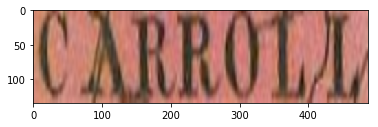

the matched words are (inorder): ['MARION']
ground truth: CARROLL
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


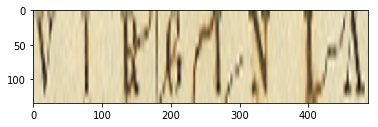

the matched words are (inorder): ['Swift']
ground truth: VIRGINIA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


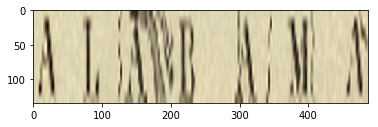

the matched words are (inorder): ['WILLIAMSON']
ground truth: ALABAMA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


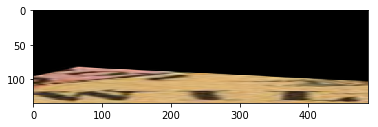

the matched words are (inorder): ['Cedar']
ground truth: WILLIAMSON
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


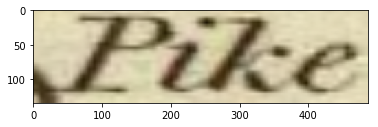

the matched words are (inorder): ['Blountville']
ground truth: Pike
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


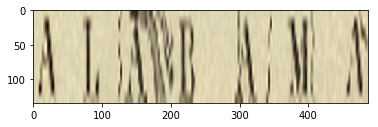

the matched words are (inorder): ['WILLIAMSON']
ground truth: ALABAMA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


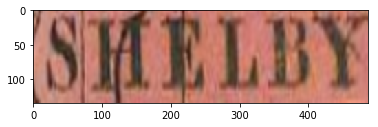

the matched words are (inorder): ['MISSOURI']
ground truth: SHELBY
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


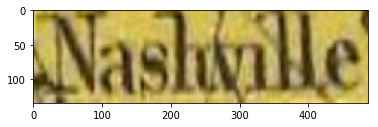

the matched words are (inorder): ['HARDIN']
ground truth: Nashville
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


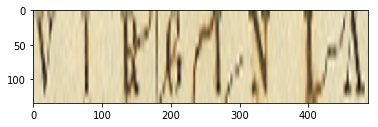

the matched words are (inorder): ['Swift']
ground truth: VIRGINIA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


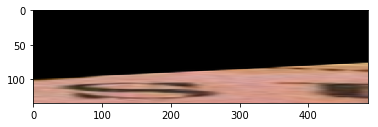

the matched words are (inorder): ['Stones']
ground truth: SUMNER
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


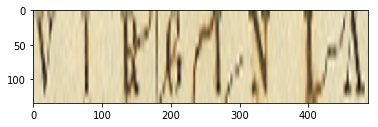

the matched words are (inorder): ['Swift']
ground truth: VIRGINIA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


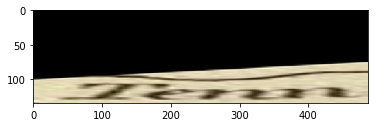

the matched words are (inorder): ['Chestatee']
ground truth: Tennessee
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


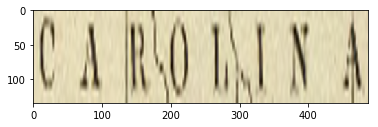

the matched words are (inorder): ['Maryville']
ground truth: CAROLINA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


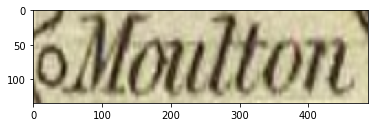

the matched words are (inorder): ['Mc.']
ground truth: Moulton
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


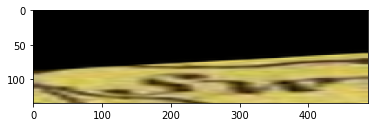

the matched words are (inorder): ['SEVIER']
ground truth: Swift
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


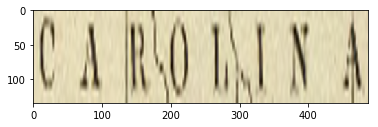

the matched words are (inorder): ['Maryville']
ground truth: CAROLINA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


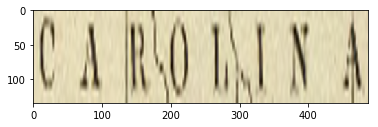

the matched words are (inorder): ['Maryville']
ground truth: CAROLINA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


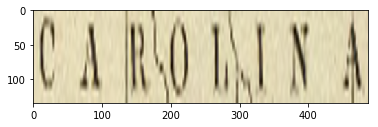

the matched words are (inorder): ['Maryville']
ground truth: CAROLINA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


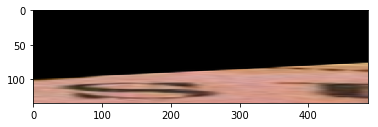

the matched words are (inorder): ['Stones']
ground truth: SUMNER
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


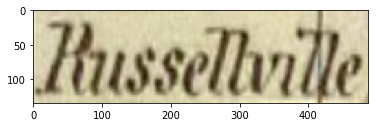

the matched words are (inorder): ['Huntsville']
ground truth: Russellville
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


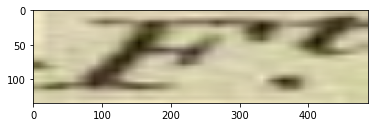

the matched words are (inorder): ['Kaskaskia']
ground truth: Ft.
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


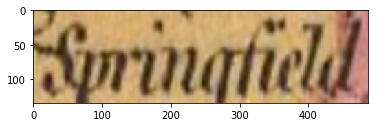

the matched words are (inorder): ['Summersville']
ground truth: Springfield
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


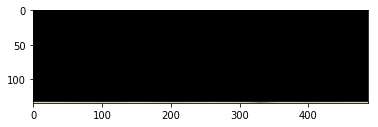

the matched words are (inorder): ['Mountains']
ground truth: miles
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


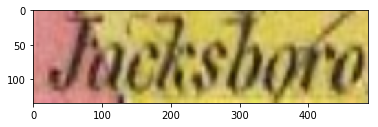

the matched words are (inorder): ['TIPTON']
ground truth: Jacksboro
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


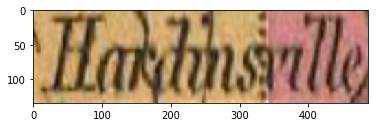

the matched words are (inorder): ['Nashville']
ground truth: Hardinsville
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


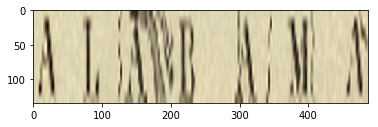

the matched words are (inorder): ['WILLIAMSON']
ground truth: ALABAMA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


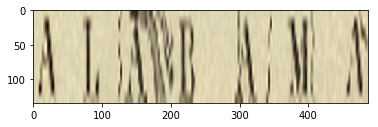

the matched words are (inorder): ['WILLIAMSON']
ground truth: ALABAMA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


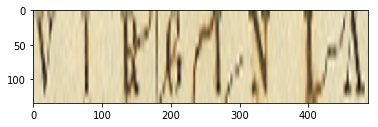

the matched words are (inorder): ['Swift']
ground truth: VIRGINIA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


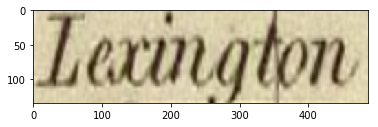

the matched words are (inorder): ['from']
ground truth: Lexington
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


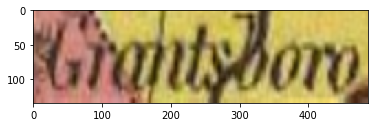

the matched words are (inorder): ['Ohio']
ground truth: Grantsboro
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


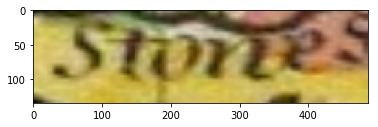

the matched words are (inorder): ['MISSISSIPPI']
ground truth: Stones
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


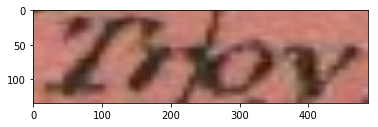

the matched words are (inorder): ['HAYWOOD']
ground truth: Troy
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


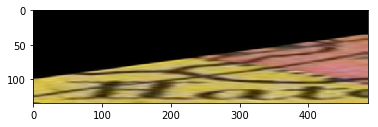

the matched words are (inorder): ['Stones']
ground truth: Hatchey
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


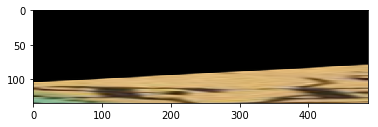

the matched words are (inorder): ['Stones']
ground truth: FENTRESS
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


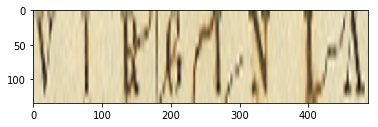

the matched words are (inorder): ['Swift']
ground truth: VIRGINIA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


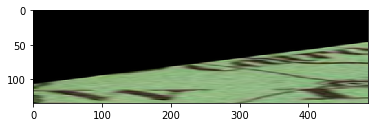

the matched words are (inorder): ['Stones']
ground truth: WILSON
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


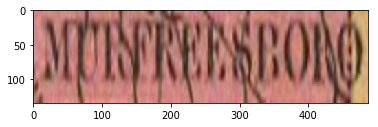

the matched words are (inorder): ['ANDERSON']
ground truth: MURFREESBORO
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


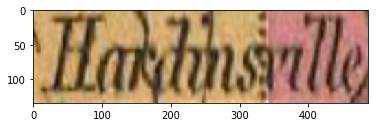

the matched words are (inorder): ['Nashville']
ground truth: Hardinsville
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


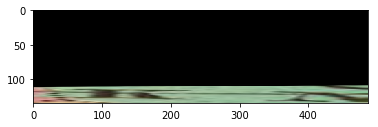

the matched words are (inorder): ['SEVIER']
ground truth: KNOX
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


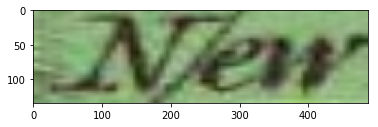

the matched words are (inorder): ['WARREN']
ground truth: New
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


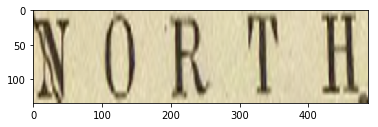

the matched words are (inorder): ['MORGAN']
ground truth: NORTH
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


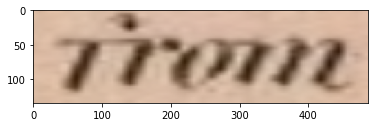

the matched words are (inorder): ['Triana']
ground truth: from
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


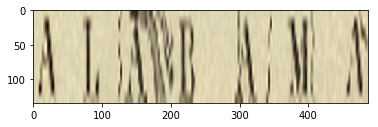

the matched words are (inorder): ['WILLIAMSON']
ground truth: ALABAMA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


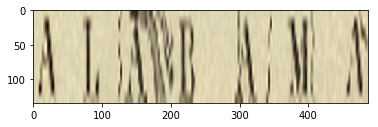

the matched words are (inorder): ['WILLIAMSON']
ground truth: ALABAMA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


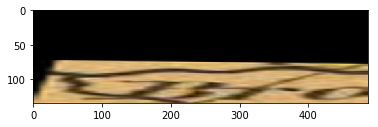

the matched words are (inorder): ['miles']
ground truth: Broad
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


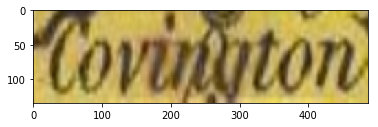

the matched words are (inorder): ['Moulton']
ground truth: Covington
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


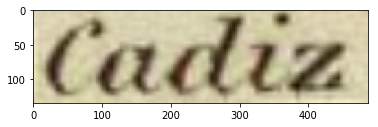

the matched words are (inorder): ['CAROLINA']
ground truth: Cadiz
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


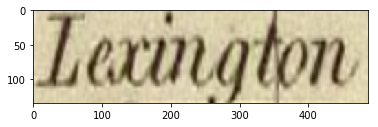

the matched words are (inorder): ['from']
ground truth: Lexington
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


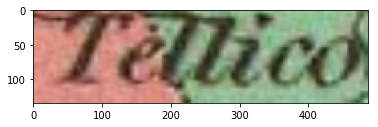

the matched words are (inorder): ['Saluda']
ground truth: Tellico
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


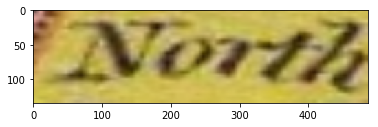

the matched words are (inorder): ['CAROLINA']
ground truth: North
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


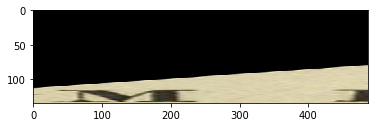

the matched words are (inorder): ['Hamilton']
ground truth: MISSISSIPPI
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


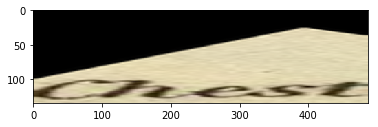

the matched words are (inorder): ['Mountains']
ground truth: Chestatee
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


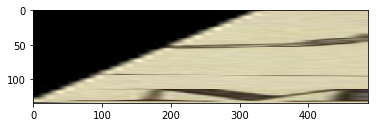

the matched words are (inorder): ['David']
ground truth: MISSOURI
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


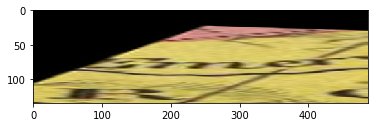

the matched words are (inorder): ['Associates,']
ground truth: ROANE
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


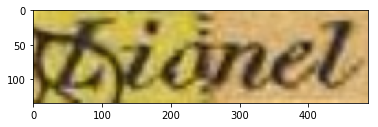

the matched words are (inorder): ['MINN']
ground truth: Lionel
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


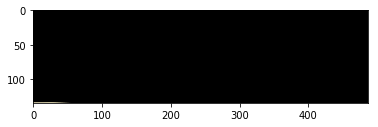

the matched words are (inorder): ['Mountains']
ground truth: CAROLINA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


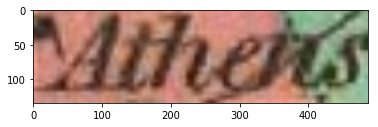

the matched words are (inorder): ['HUMPHRIES']
ground truth: Athens
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


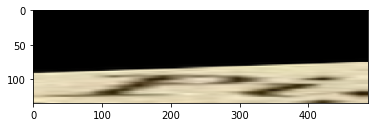

the matched words are (inorder): ['Ockmulgee']
ground truth: Pigeon
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


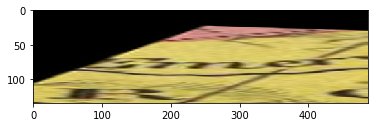

the matched words are (inorder): ['Associates,']
ground truth: ROANE
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


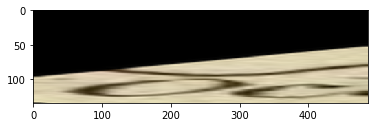

the matched words are (inorder): ['Stones']
ground truth: Ockmulgee
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


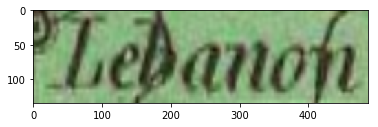

the matched words are (inorder): ['Tellico']
ground truth: Lebanon
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


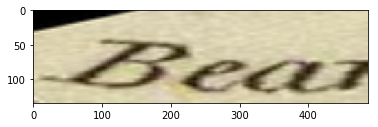

the matched words are (inorder): ['New']
ground truth: Bear
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


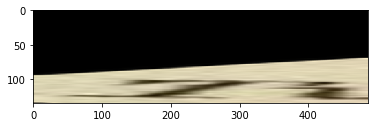

the matched words are (inorder): ['ROANE']
ground truth: Tugaloo
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


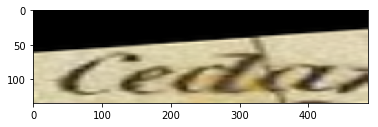

the matched words are (inorder): ['Philada.']
ground truth: Cedar
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


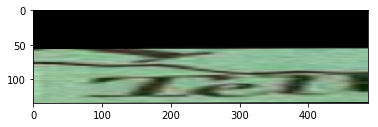

the matched words are (inorder): ['Pigeon']
ground truth: Tellico
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


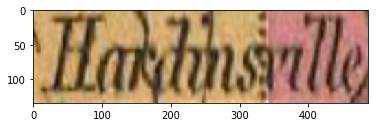

the matched words are (inorder): ['Nashville']
ground truth: Hardinsville
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


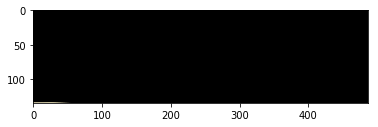

the matched words are (inorder): ['Mountains']
ground truth: CAROLINA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


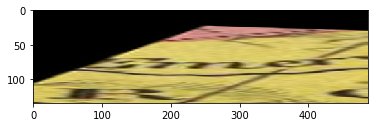

the matched words are (inorder): ['Associates,']
ground truth: ROANE
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


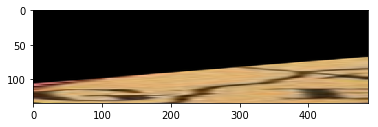

the matched words are (inorder): ['Florence']
ground truth: GREENE
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


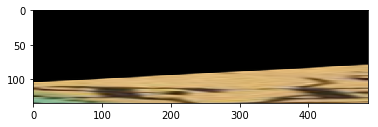

the matched words are (inorder): ['Stones']
ground truth: FENTRESS
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


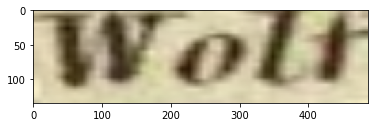

the matched words are (inorder): ['BLOUNT']
ground truth: Wolf
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


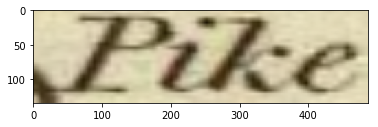

the matched words are (inorder): ['Blountville']
ground truth: Pike
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


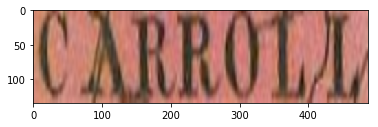

the matched words are (inorder): ['MARION']
ground truth: CARROLL
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


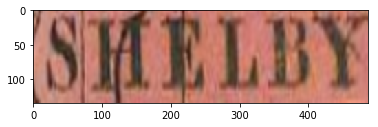

the matched words are (inorder): ['MISSOURI']
ground truth: SHELBY
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


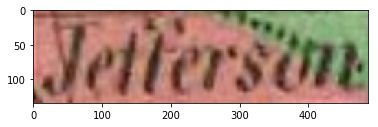

the matched words are (inorder): ['WILSON']
ground truth: Jefferson
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


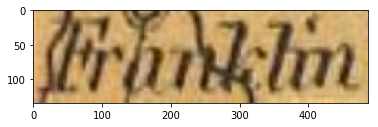

the matched words are (inorder): ['HUMPHRIES']
ground truth: Franklin
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


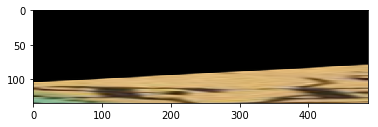

the matched words are (inorder): ['Stones']
ground truth: FENTRESS
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


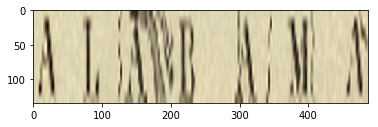

the matched words are (inorder): ['WILLIAMSON']
ground truth: ALABAMA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


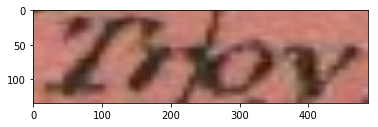

the matched words are (inorder): ['HAYWOOD']
ground truth: Troy
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


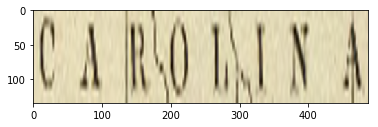

the matched words are (inorder): ['Maryville']
ground truth: CAROLINA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


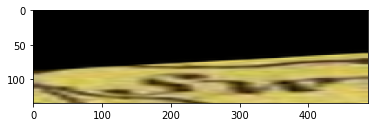

the matched words are (inorder): ['SEVIER']
ground truth: Swift
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


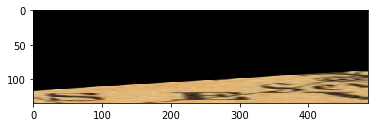

the matched words are (inorder): ['GILES']
ground truth: SEVIER
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


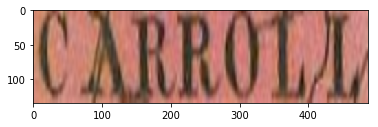

the matched words are (inorder): ['MARION']
ground truth: CARROLL
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


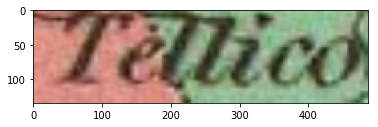

the matched words are (inorder): ['Saluda']
ground truth: Tellico
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


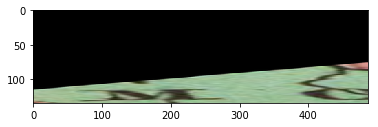

the matched words are (inorder): ['MISSOURI']
ground truth: Monroe
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


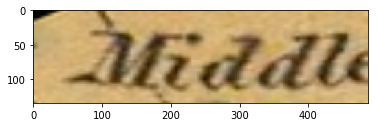

the matched words are (inorder): ['Saluda']
ground truth: Middle
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


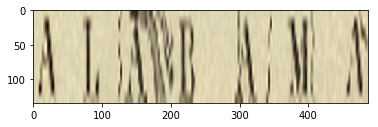

the matched words are (inorder): ['WILLIAMSON']
ground truth: ALABAMA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


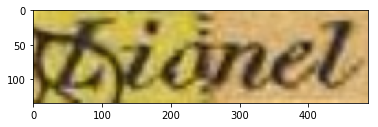

the matched words are (inorder): ['MINN']
ground truth: Lionel
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


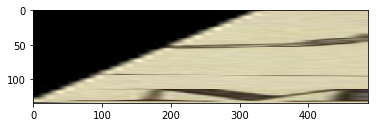

the matched words are (inorder): ['David']
ground truth: MISSOURI
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


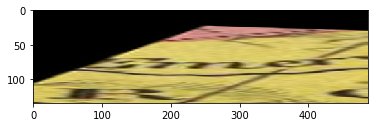

the matched words are (inorder): ['Associates,']
ground truth: ROANE
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


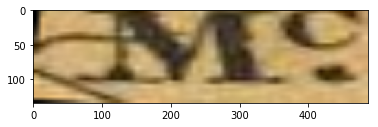

the matched words are (inorder): ['Longitude']
ground truth: Mc.
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


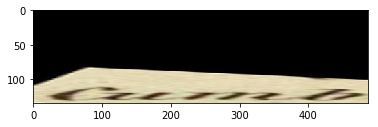

the matched words are (inorder): ['COCKE']
ground truth: Cumberland
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


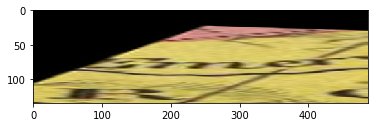

the matched words are (inorder): ['Associates,']
ground truth: ROANE
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


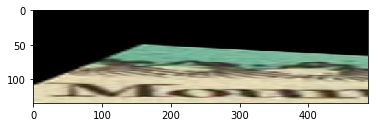

the matched words are (inorder): ['Loosahatchey']
ground truth: Mountains
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


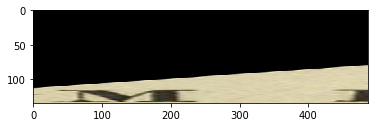

the matched words are (inorder): ['Hamilton']
ground truth: MISSISSIPPI
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


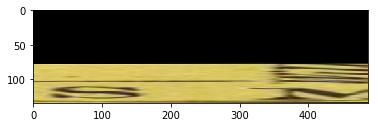

the matched words are (inorder): ['Mountains']
ground truth: SMITH
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


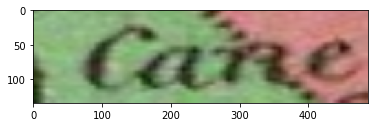

the matched words are (inorder): ['Cadiz']
ground truth: Cane
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


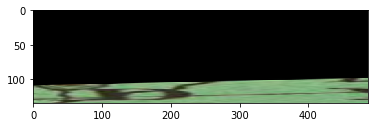

the matched words are (inorder): ['CAROLINA']
ground truth: DYER
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


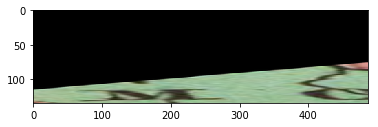

the matched words are (inorder): ['MISSOURI']
ground truth: Monroe
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


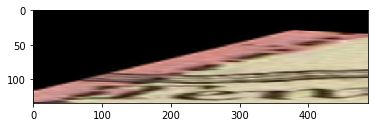

the matched words are (inorder): ['Pigeon']
ground truth: Tennessee
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


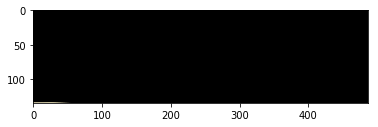

the matched words are (inorder): ['Mountains']
ground truth: CAROLINA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


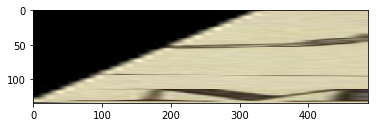

the matched words are (inorder): ['David']
ground truth: MISSOURI
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


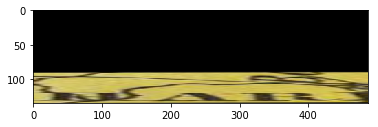

the matched words are (inorder): ['Stones']
ground truth: HARDIMAN
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


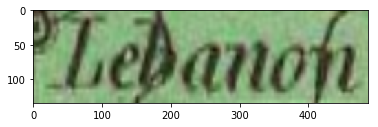

the matched words are (inorder): ['Tellico']
ground truth: Lebanon
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


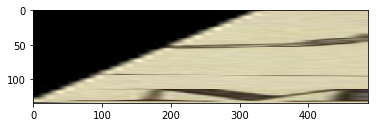

the matched words are (inorder): ['David']
ground truth: MISSOURI
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


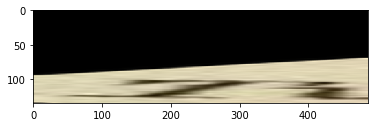

the matched words are (inorder): ['ROANE']
ground truth: Tugaloo
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


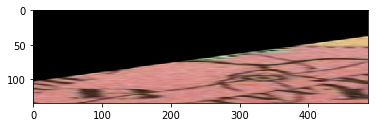

the matched words are (inorder): ['GILES']
ground truth: BLOUNT
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


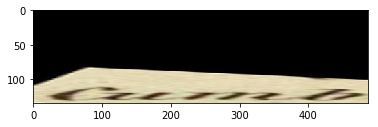

the matched words are (inorder): ['COCKE']
ground truth: Cumberland
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


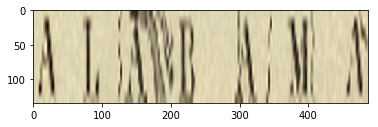

the matched words are (inorder): ['WILLIAMSON']
ground truth: ALABAMA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


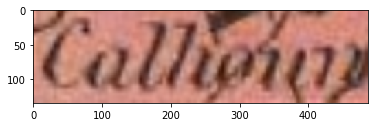

the matched words are (inorder): ['CAROLINA']
ground truth: Calhoun
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


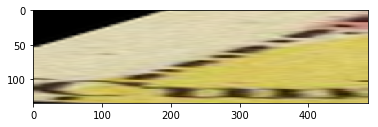

the matched words are (inorder): ['North']
ground truth: Cumberland
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


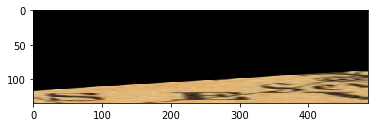

the matched words are (inorder): ['GILES']
ground truth: SEVIER
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


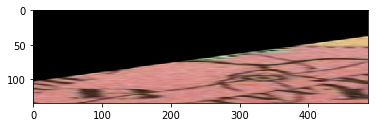

the matched words are (inorder): ['GILES']
ground truth: BLOUNT
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


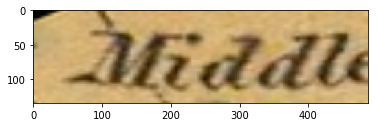

the matched words are (inorder): ['Saluda']
ground truth: Middle
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


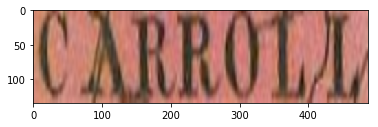

the matched words are (inorder): ['MARION']
ground truth: CARROLL
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


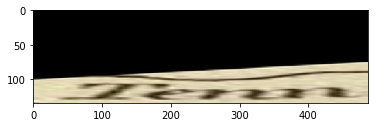

the matched words are (inorder): ['Chestatee']
ground truth: Tennessee
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


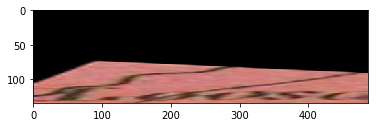

the matched words are (inorder): ['Coldwater']
ground truth: Loosahatchey
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


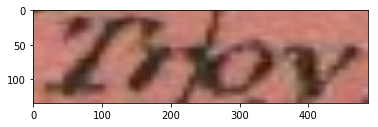

the matched words are (inorder): ['HAYWOOD']
ground truth: Troy
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


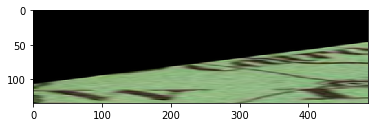

the matched words are (inorder): ['Stones']
ground truth: WILSON
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


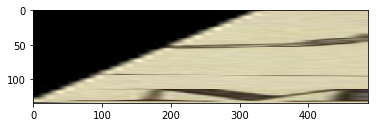

the matched words are (inorder): ['David']
ground truth: MISSOURI
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


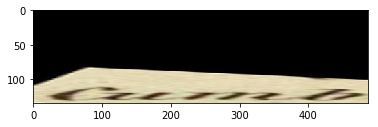

the matched words are (inorder): ['COCKE']
ground truth: Cumberland
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


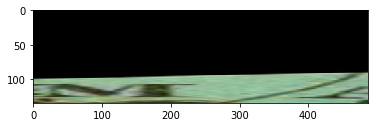

the matched words are (inorder): ['HUMPHRIES']
ground truth: MARION
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


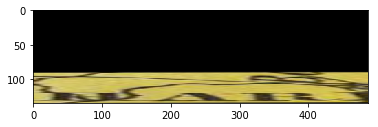

the matched words are (inorder): ['Stones']
ground truth: HARDIMAN
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


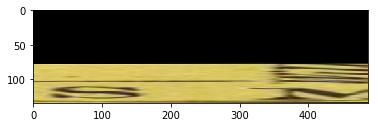

the matched words are (inorder): ['Mountains']
ground truth: SMITH
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


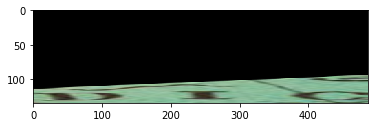

the matched words are (inorder): ['Stones']
ground truth: DICKSON
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


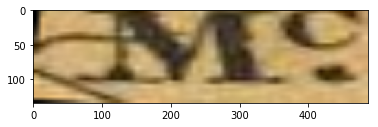

the matched words are (inorder): ['Longitude']
ground truth: Mc.
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


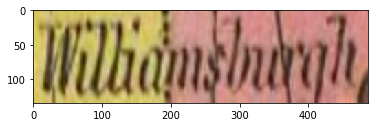

the matched words are (inorder): ['MINN']
ground truth: Williamsburgh
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


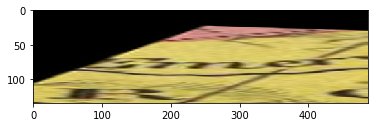

the matched words are (inorder): ['Associates,']
ground truth: ROANE
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


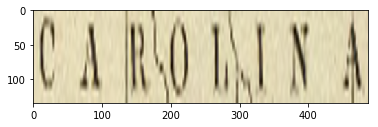

the matched words are (inorder): ['Maryville']
ground truth: CAROLINA
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


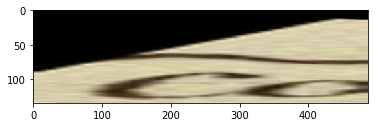

the matched words are (inorder): ['Stones']
ground truth: Coosa
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


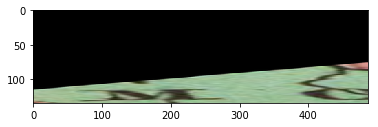

the matched words are (inorder): ['MISSOURI']
ground truth: Monroe
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


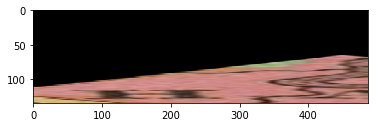

the matched words are (inorder): ['Florence']
ground truth: HARDIN
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


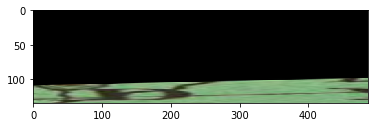

the matched words are (inorder): ['CAROLINA']
ground truth: DYER
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


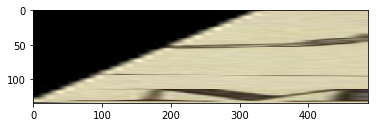

the matched words are (inorder): ['David']
ground truth: MISSOURI
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


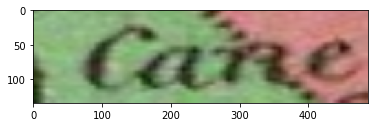

the matched words are (inorder): ['Cadiz']
ground truth: Cane
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


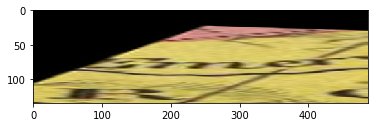

the matched words are (inorder): ['Associates,']
ground truth: ROANE
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


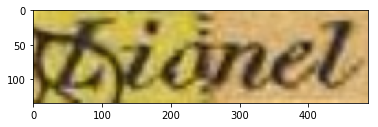

the matched words are (inorder): ['MINN']
ground truth: Lionel
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


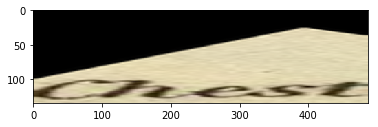

the matched words are (inorder): ['Mountains']
ground truth: Chestatee
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


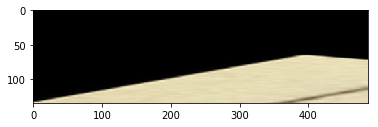

the matched words are (inorder): ['FENTRESS']
ground truth: Kentucky
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


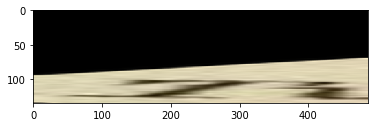

the matched words are (inorder): ['ROANE']
ground truth: Tugaloo
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


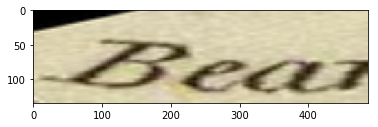

the matched words are (inorder): ['New']
ground truth: Bear
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


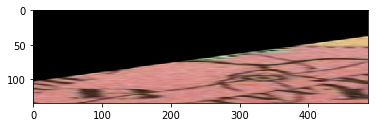

the matched words are (inorder): ['GILES']
ground truth: BLOUNT
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


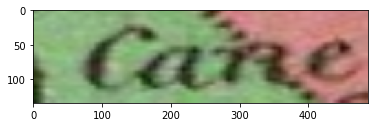

the matched words are (inorder): ['Cadiz']
ground truth: Cane
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


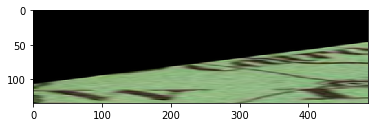

the matched words are (inorder): ['Stones']
ground truth: WILSON
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


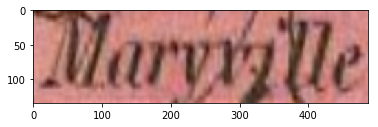

the matched words are (inorder): ['North']
ground truth: Maryville
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


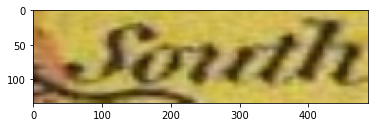

the matched words are (inorder): ['SMITH']
ground truth: South
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


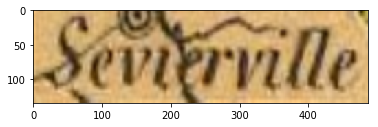

the matched words are (inorder): ['CARROLL']
ground truth: Sevierville
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


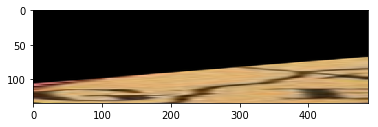

the matched words are (inorder): ['Florence']
ground truth: GREENE
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


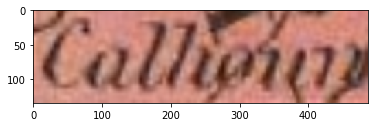

the matched words are (inorder): ['CAROLINA']
ground truth: Calhoun
------------------------------------------------------------------------
------------------------------------------------------------------------


In [34]:
import matplotlib.pyplot as plt

count, matched_words, new_outputs, new_embedding, new_word_strings, \
    qualified_ids = report_matches(outputs, embedding, 'cosine', word_strings, 1, 2)

print A[0] + " the accuracy is: "+str(count/float(len(new_word_strings)))
print count
print len(new_word_strings)

_len = min(500, len(matched_words))
new_images = images[qualified_ids]
for i in range(_len):
    if str(matched_words[i][0]) != str(new_word_strings[i]):
        print "************************************************************************"
        print "************************************************************************"
        print "Original image:"
        q = np.transpose(new_images[i],(1,2,0))
        plt.imshow(q)
        plt.show()
        print "the matched words are (inorder): "+str(matched_words[i])
        print 'ground truth: ' + str(new_word_strings[i])
        print "------------------------------------------------------------------------"
        print "------------------------------------------------------------------------"
pass